# HIV Methylation Age: Epigenetic Coorelates of Age Advancement

### Imports and Helper Functions

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/Methlation


In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [3]:
import Parallel.Age_HIV_Features as fx

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

In [4]:
from Setup.DX_Imports import ttest_df

importing IPython notebook from Setup/DX_Imports

In [5]:
(fx.rr > 0).value_counts()

False    411452
True      61592
dtype: int64

In [6]:
fx.rr.value_counts()

0    411452
1     34665
2     26927
dtype: int64

In [7]:
r2 = ti(fx.rr > 1)
direction = fx.res.in_set_s1.multi_variate.age > 0
r3 = ti(((fx.mm < .5).ix[r2] == direction.ix[r2]) == False)
len(r3)

7967

### Unsupervised Analysis of Age-Associated Probes

* Now we are taking these age associated probes and looking in our new dataset for broad trends 
* For now, mainly I'm just doing basic PCA on the normalized dataset

In [96]:
df_hiv2 = fx.df_hiv.ix[:, fx.duration.index]
df_hiv2 = df_hiv2.dropna(1, how='all')

dd = logit_adj(df_hiv2)
m = dd.mean(1)
s = dd.std(1)
df_norm = dd.subtract(m, axis=0).divide(s, axis=0)

In [97]:
idx = r3
U,S,vH = frame_svd(df_norm.ix[idx])

The first PC captures about 25% of the variance in the data

In [98]:
p = S ** 2 / sum(S ** 2)
p[:5]

array([ 0.14613607,  0.09732037,  0.04516041,  0.03142676,  0.02604059])

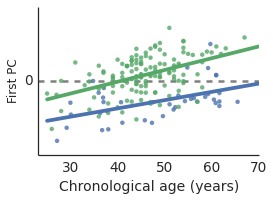

In [99]:
fig, ax = subplots(1,1, figsize=(4,3))
rr = 1*vH[0]
k = fx.pred_c.index
hiv = fx.duration.ix[rr.index].dropna() != 'Control'
age = fx.age

sns.regplot(*match_series(age.ix[k], rr.ix[ti(hiv==0)]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age.ix[k], rr.ix[ti(hiv>0)]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('First PC', size=12)
ax.set_xlabel('Chronological age (years)', size=14)

ax.set_yticks([0])
ax.axhline(0, ls='--', lw=2.5, color='grey', zorder=-1)
ax.set_xbound(23,70)
ax.set_ybound(-.25,.25)
prettify_ax(ax)
fig.tight_layout()
fig.savefig(FIGDIR + 'PC1_validated.pdf')

Here I am doing a drop-1 test for an interaction term of age X HIV.  In the second act of this analysis we filter a few more patients with data that doesn't agree between aging models.  In general I think these are bad samples, and removing them does improve this result and make the lines more parallel than shown here.  I'm not using these filters here because it seemed a little ad-hoc to go back and apply them before we even looked at aging models and it is generally hard to report an iterative analysis in a journal paper.

In [100]:
import statsmodels.api as sm

In [101]:
y = vH[0]
intercept = pd.Series(1, index=y.index)

X = pd.concat([intercept, age, hiv], axis=1, keys=['Intercept', 'age', 'HIV'])
X = X.dropna().ix[y.index]
m1 = sm.OLS(y, X).fit()

X = pd.concat([intercept, age, hiv, hiv*age], axis=1, keys=['Intercept', 'age', 'HIV', 'int'])
X = X.dropna().ix[y.index]
m2 = sm.OLS(y, X).fit()

m2.compare_lr_test(m1)

(1.1298061889274322, 0.28781668290682894, 1.0)

In [102]:
m2.pvalues

Intercept    5.41e-08
age          1.19e-04
HIV          3.11e-01
int          2.94e-01
dtype: float64

In [103]:
m1.pvalues

Intercept    4.79e-18
age          6.42e-12
HIV          3.07e-18
dtype: float64

Here I'm calculating the effect sise of HIV presence across the top principal components.  The idea is that an effect of 25 years means the the presence of HIV has an equivalent effect as 25 years of age on the molecular signal. 

In [106]:
cc = {}
for i,y in vH.iteritems():
    mod_all = sm.OLS(y, X)
    res_ref = mod_all.fit()
    cc[i] = res_ref.params['HIV'] / res_ref.params['age']
cc = pd.Series(cc)
cc.head()

0    16.23
1    48.20
2   -10.29
3    19.65
4   -35.27
dtype: float64

In [107]:
def entropy(p):
    '''
    Entropy of a methylaion vector. Here we assume 50% methylation is 
    random and 0 or 1 constitute an informative measument. 
    '''
    q = 1. - p
    s = np.sum((p*np.log(p)) + (q*np.log(q))) / (np.log(.5) * len(p))
    s.name = 'Entropy'
    return s

In [108]:
def disorder_frac(direction, beta, test_set):
    ct = pd.crosstab(beta < .5, direction.ix[test_set]>0)
    return (1.*ct[1][1] + ct[0][0]) / ct.sum().sum()

In [109]:
from Setup.MethylationAgeModels import *

In [110]:
model_idx = hannum_model.index.union(horvath_model.index)

In [111]:
disorder_frac(fx.res.in_set_s1.multi_variate.age, fx.mm, model_idx)

0.5298165137614679

In [112]:
disorder_frac(fx.res.in_set_s1.multi_variate.age, fx.mm, model_idx) * len(model_idx)

231.0

In [113]:
231 / 436.

0.5298165137614679

In [114]:
stats.binom_test(231, n=436)

0.2311578847176522

In [115]:
model_idx = hannum_model.index.union(horvath_model.index)
d1 = disorder_frac(fx.res.in_set_s1.multi_variate.age, fx.mm, model_idx)
d2 = disorder_frac(fx.r4.multi_variate.HIV, fx.mm, model_idx)

<Container object of 2 artists>

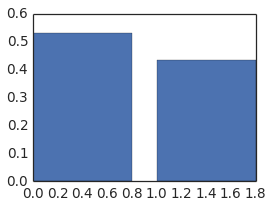

In [116]:
fig, ax = subplots(figsize=(4,3))
ax.bar([0,1], [d1,d2])

In [118]:
model_entropy = entropy(df_hiv2.ix[model_idx, hiv.index])
all_entropy = entropy(df_hiv2.ix[fx.probe_idx, hiv.index])

In [129]:
zscore = lambda s: (s - s.mean()) / s.std()
e2 = all_entropy.groupby(hiv).apply(zscore)
all_entropy[e2.abs() > 3]

Sample_Name
METI-8         0.68
RM067          0.66
Name: Entropy, dtype: float64

In [121]:
e2 = model_entropy.groupby(hiv).apply(zscore)
model_entropy[e2.abs() > 3]

Sample_Name
RA223          0.68
RM067          0.71
Name: Entropy, dtype: float64

In [123]:
fx.hiv.value_counts()

HIV+    137
HIV-     42
dtype: int64

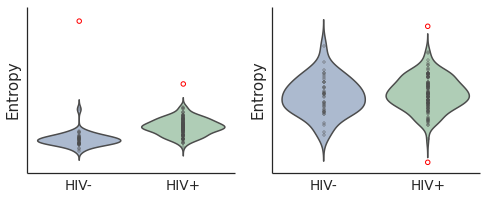

In [124]:
fig, axs = subplots(1,2, figsize=(7,3))

zscore = lambda s: (s - s.mean()) / s.std()
e2 = all_entropy.groupby(hiv).apply(zscore)
sns.violinplot(all_entropy[e2.abs() < 3], fx.hiv, ax=axs[0], 
               order=['HIV-','HIV+'],
               inner='points', inner_kws={"ms": 8}, alpha=.5,
               bw='scott')
axs[0].scatter([1,2], all_entropy[e2.abs() > 3], color='white', edgecolor='red',
               alpha=1, s=20, lw=1)

e2 = model_entropy.groupby(hiv).apply(zscore)
sns.violinplot(model_entropy[e2.abs() < 3], fx.hiv, ax=axs[1], 
               order=['HIV-','HIV+'],
               inner='points', inner_kws={"ms": 8}, alpha=.5,
               bw='scott')
axs[1].scatter([2,2], model_entropy[e2.abs() > 3], color='white', edgecolor='red',
               alpha=1, s=20, lw=1)

for ax in axs:
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('Entropy')
    prettify_ax(ax)
fig.tight_layout()

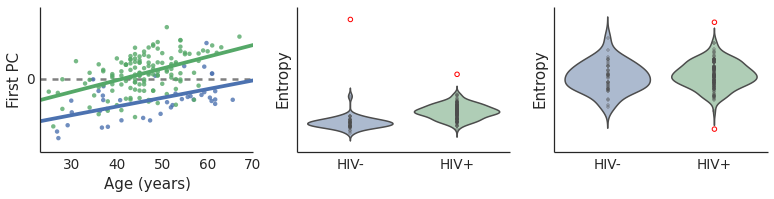

In [128]:
fig, axs = subplots(1,3, figsize=(11,3), sharey=False)

rr = vH[0]
hiv = (fx.duration != 'Control').map({True:'HIV+',False:'HIV-'})

ax=axs[0]
sns.regplot(*match_series(age, rr.ix[ti(hiv=='HIV-')]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age, rr.ix[ti(hiv=='HIV+')]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('First PC')
ax.set_xlabel('Age (years)')
ax.set_yticks([0])
ax.axhline(0, ls='--', color='grey', zorder=-1)
ax.set_xbound(23,70)
ax.set_ybound(-.25,.25)
prettify_ax(ax)

ax = axs[1]
zscore = lambda s: (s - s.mean()) / s.std()
e2 = all_entropy.groupby(hiv).apply(zscore)
sns.violinplot(all_entropy[e2.abs() < 3], hiv, ax=ax, 
               order=['HIV-','HIV+'],
               inner='points', inner_kws={"ms": 8}, alpha=.5,
               bw='scott')
ax.scatter([1,2], all_entropy[e2.abs() > 3], color='white', edgecolor='red',
               alpha=1, s=20, lw=1)

ax = axs[2]
e2 = model_entropy.groupby(hiv).apply(zscore)
sns.violinplot(model_entropy[e2.abs() < 3], hiv, ax=ax, 
               order=['HIV-','HIV+'],
               inner='points', inner_kws={"ms": 8}, alpha=.5,
               bw='scott')
ax.scatter([2,2], model_entropy[e2.abs() > 3], color='white', edgecolor='red',
               alpha=1, s=20, lw=1)
ax.set_ybound(.67,.72)

for ax in axs[1:]:
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('Entropy')
    prettify_ax(ax)
fig.tight_layout()
fig.savefig(FIGDIR + 'xd_F4.pdf')

In [147]:
hiv.value_counts()

HIV+    137
HIV-     42
dtype: int64

In [146]:
kruskal_pandas(hiv, all_entropy)

H    5.61e+01
p    6.97e-14
dtype: float64

In [148]:
kruskal_pandas(hiv, model_entropy)

H    1.02
p    0.31
dtype: float64

In [73]:
import Setup.DX_Imports as dx

In [74]:
features = {'Age only': fx.features['Age (BH)'],
            'HIV + Age': fx.features['HIV + Age (BH)'],
            'HIV only': fx.features['HIV (BH)']}

probes_sets = {'PRC2': dx.prc2_probes, 'CpG island': dx.cpg_island,
               'DHS': dx.dhs_site, 'Enhancer': dx.enhancer,
               'Gene body': dx.gene_body, 'TSS': dx.gene_tss,
               'Promoter': dx.promoter}

In [77]:
associations = {}
for i,a in features.iteritems():
    for j,b in probes_sets.iteritems():
        associations[(i,j)] = fisher_exact_test(a,b)

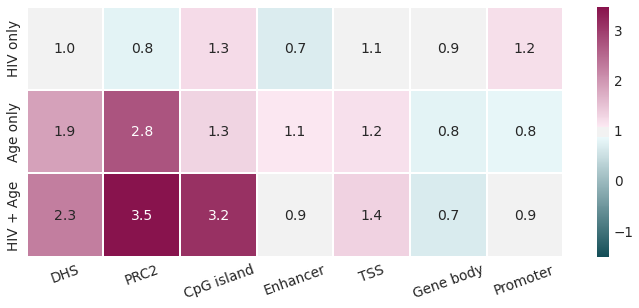

In [82]:
fig, ax = subplots(figsize=(10,4.5))
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
o = ['DHS','PRC2','CpG island','Enhancer', 'TSS','Gene body','Promoter']
p = ['HIV only', 'Age only', 'HIV + Age']
#p = ['Age', 'HIV']
df = pd.concat(associations).unstack()['odds_ratio'].unstack().T
r = sns.heatmap(df.ix[o,p].T, cmap=cmap, center=1, annot=True, fmt='0.1f')
ax.set_xticklabels(o, rotation=20, ha='center')
fig.tight_layout()